<a href="https://colab.research.google.com/github/LeonardoVieiraGuimaraes/MiniCursoPalestra/blob/main/CNN/reconhecerNumero/simple_cnn_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN simples para Google Colab (treino MNIST)

Resumo: Este notebook prepara, treina e avalia uma CNN simples no conjunto MNIST. Ele foi pensado para rodar no Google Colab (GPU opcional) ou localmente em um ambiente Python com TensorFlow instalado.

Pré-requisitos:
- Python 3.8+ e TensorFlow compatível (no Colab, o runtime já oferece TF).
- (Opcional) GPU no Colab para acelerar o treinamento.

Como usar:
1. Execute as células na ordem apresentada.
2. Na célula de instalação (se em Colab) permita a instalação de dependências quando solicitado.
3. Ajuste hiperparâmetros (epochs, batch_size) na célula de treino se desejar.
4. Ao final, salve o modelo com a célula de salvamento (opcionalmente no Google Drive).

Arquivos gerados esperados:
- `best_model.h5` (melhor checkpoint local).
- `simple_cnn_mnist.h5` (arquivo salvo opcional).

Entradas / Saídas:
- Entrada: nenhum arquivo externo é necessário (os dados MNIST são baixados automaticamente).
- Saída: modelos salvos em disco + gráficos do histórico de treino e métricas de teste.

Notas e dicas:
- Use `validation_split` pequeno (ex.: 0.1) para validação rápida.
- Se desejar reproduzir resultados, defina uma semente RNG antes do trecho de treino.
- Para experimentar com outros datasets (Fashion-MNIST, CIFAR-10), adapte a célula de carregamento dos dados.

Instalação condicional (Colab):
Detecta execução em Colab e instala pacotes; atenção: evitar reinstalar TensorFlow no Colab para não causar conflitos.

In [ ]:
# Célula 1 — Instala dependências (apenas no Colab)
# Detecta Colab de forma segura e instala pacotes necessários.
try:
    import google.colab
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    print('Google Colab detectado — instalando dependências (tensorflow, matplotlib, numpy) ...')
    import subprocess, sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'tensorflow', 'matplotlib', 'numpy'])
    print('Instalação concluída. Reinicie o runtime se necessário.')
else:
    print('Não detectado Google Colab. Para instalar localmente, execute:')
    print(r'python -m pip install tensorflow matplotlib numpy')

Google Colab detectado — instalando dependências (tensorflow, matplotlib, numpy) ...
Instalação concluída. Reinicie o runtime se necessário.


Checar ambiente:
Importa as bibliotecas principais e mostra versão do TensorFlow e GPUs disponíveis. Útil para confirmar que o ambiente tem aceleração por hardware.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print('TensorFlow version:', tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print('GPUs found:', gpus)

TensorFlow version: 2.19.0
GPUs found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Carregar MNIST e pré-processar:
Baixa MNIST (se necessário), normaliza pixels para [0,1] e ajusta dimensões para o modelo (batch, height, width, channel). Mostra algumas amostras.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28, 1) y_train shape: (60000,)


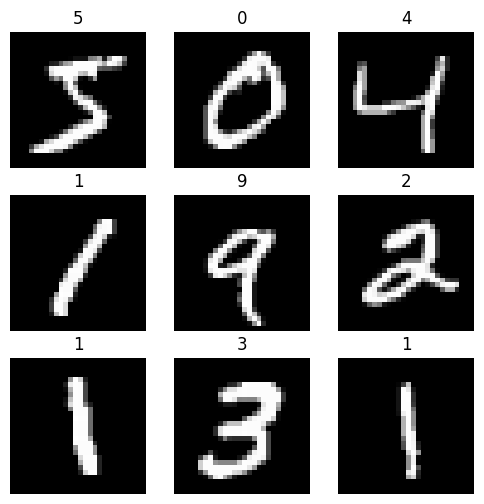

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalizar e expandir canal
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)  # (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, -1)

print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)

# Mostrar as 9 primeiras imagens de treino
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(str(y_train[i]))
    plt.axis('off')
plt.show()

Definir arquitetura da CNN:
Função que constrói um modelo Sequential teste com duas camadas convolucionais, pooling, flatten e dense final. Use essa célula para modificar arquitetura ou hiperparâmetros.

In [4]:
from tensorflow.keras import layers, models

def build_simple_cnn(input_shape=(28,28,1), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_simple_cnn()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Compilar e treinar:
Compila o modelo com optimizer e loss e inicia o treinamento com EarlyStopping e ModelCheckpoint para salvar o melhor estado.

In [5]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Salvar melhor modelo localmente (runtime)
checkpoint_path = 'best_model.h5'
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
]

history = model.fit(x_train, y_train,
                    epochs=15,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks=callbacks)

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8013 - loss: 0.6392

422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.8015 - loss: 0.6384 - val_accuracy: 0.9833 - val_loss: 0.0592
Epoch 2/15
421/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9729 - loss: 0.0904

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9729 - loss: 0.0904 - val_accuracy: 0.9875 - val_loss: 0.0443
Epoch 3/15
421/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9808 - loss: 0.0662

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9808 - loss: 0.0662 - val_accuracy: 0.9893 - val_loss: 0.0393
Epoch 4/15
420/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9833 - loss: 0.0524

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9833 - loss: 0.0523 - val_accuracy: 0.9907 - val_loss: 0.0346
Epoch 5/15
420/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9873 - loss: 0.0421

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9873 - loss: 0.0421 - val_accuracy: 0.9900 - val_loss: 0.0323
Epoch 6/15
417/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9899 - loss: 0.0351

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9899 - loss: 0.0351 - val_accuracy: 0.9913 - val_loss: 0.0300
Epoch 7/15
417/422 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9890 - loss: 0.0319

422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9890 - loss: 0.0319 - val_accuracy: 0.9918 - val_loss: 0.0295
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9928 - loss: 0.0245 - val_accuracy: 0.9918 - val_loss: 0.0316
Epoch 9/15
419/422 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9929 - loss: 0.0232

422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9929 - loss: 0.0232 - val_accuracy: 0.9925 - val_loss: 0.0291
Epoch 10/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9934 - loss: 0.0200 - val_accuracy: 0.9913 - val_loss: 0.0322
Epoch 11/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9933 - loss: 0.0199 - val_accuracy: 0.9923 - val_loss: 0.0319
Epoch 12/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9946 - loss: 0.0163 - val_accuracy: 0.9928 - val_loss: 0.0356
Epoch 13/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9949 - loss: 0.0155 - val_accuracy: 0.9920 - val_loss: 0.0353
Epoch 14/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9952 - loss: 0.0138 - val_accuracy: 0.9930 - val_loss: 0.0325


Plot das curvas de treino:
Plota loss/val_loss e accuracy/val_accuracy usando o histórico retornado pelo `model.fit`. Útil para inspecionar overfitting ou instabilidade.

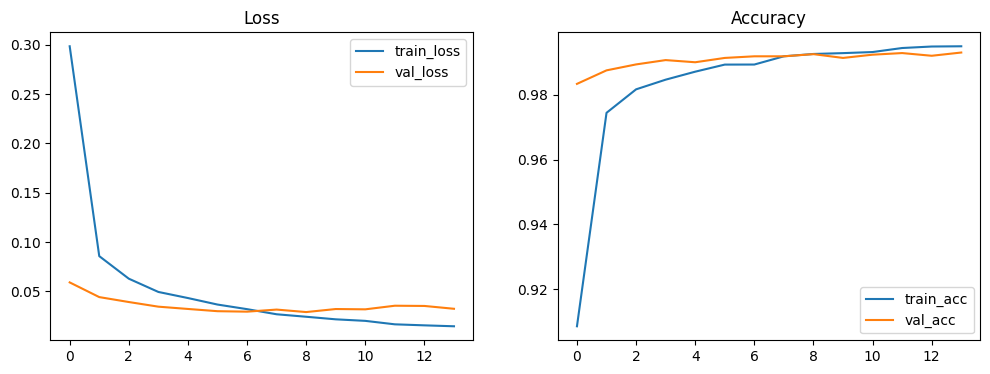

In [6]:
# Plot das curvas de treino/validação
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy')
plt.show()

Avaliar no conjunto de teste:
Executa `model.evaluate` sobre `x_test`/`y_test` e imprime métricas finais. Se quiser avaliar o checkpoint salvo, carregue `best_model.h5` antes.

In [7]:
# Avaliar no conjunto de teste
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')

313/313 - 2s - 6ms/step - accuracy: 0.9922 - loss: 0.0234
Test accuracy: 0.9922, Test loss: 0.0234


Visualizar previsões:
Mostra as primeiras 25 imagens do conjunto de teste com previsões e coloração dos rótulos (verde correto, vermelho incorreto).

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


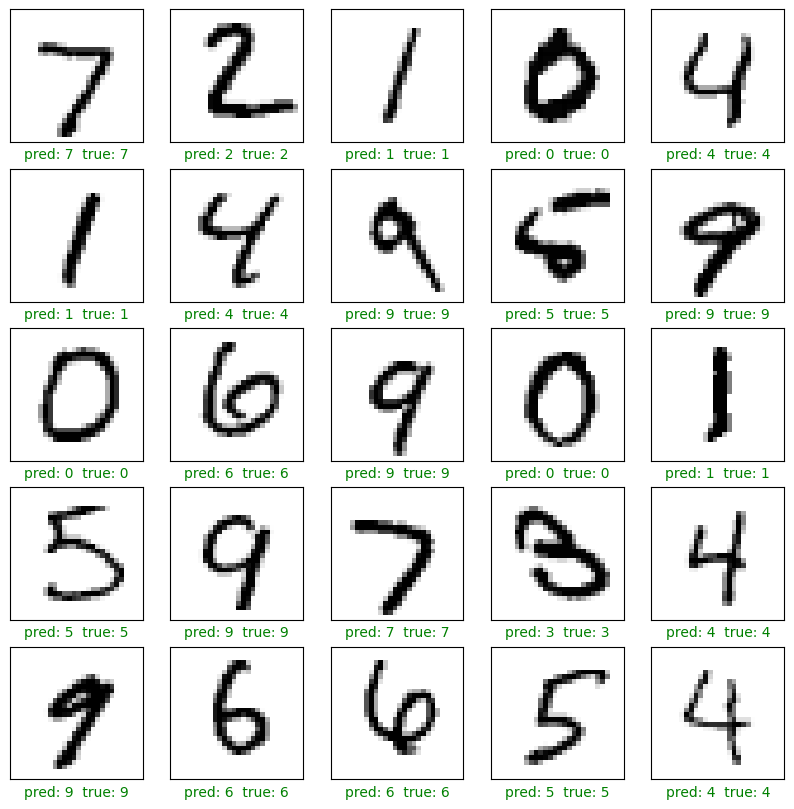

In [8]:
preds = model.predict(x_test[:25])
pred_labels = np.argmax(preds, axis=1)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i].squeeze(), cmap=plt.cm.binary)
    color = 'green' if pred_labels[i] == y_test[i] else 'red'
    plt.xlabel(f'pred: {pred_labels[i]}  true: {y_test[i]}', color=color)
plt.show()

Salvar modelo no Drive (opcional):
Se estiver no Colab, monte o Drive e salve o modelo. Em ambiente local, salva no arquivo `simple_cnn_mnist.h5`.

In [9]:
# Célula opcional: salvar em Google Drive (executar apenas em Colab)
try:
    import google.colab
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    dest = '/content/drive/MyDrive/simple_cnn_mnist.h5'
    model.save(dest)
    print('Modelo salvo em', dest)
else:
    # Salvar localmente no runtime (download manual depois)
    local_path = 'simple_cnn_mnist.h5'
    model.save(local_path)
    print('Modelo salvo localmente em', local_path)

Mounted at /content/drive
Modelo salvo em /content/drive/MyDrive/simple_cnn_mnist.h5
